### Media Bias Detection (Using Softmax-Based Neutrosophic Loss)

##### 1. Imports

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input

##### 2. Load Processed Dataset

In [14]:
file = r"/kaggle/input/bias-detection-dataset-processed/balanced_bias_data_parquet.parquet"
balanced_df = pd.read_parquet(file)

print(balanced_df)
print("\nColumns:", balanced_df.columns)
print("\Shape:", balanced_df.shape)

         Unnamed: 0                                               text  \
0                 0  im okay with it being there and im not religious.   
1                 1  nn chchchchina nnlets dialogue about this wond...   
2                 2  ianbetteridge firefox2, no idea what version o...   
3                 3  so kool!i didnt know he came to alaska.i was 1...   
4                 4  catwoman123 if you know the real demi moore an...   
...             ...                                                ...   
2856798     2856798  i see that someone answered on your talk page....   
2856799     2856799  sheriff joe as you affectionately call him had...   
2856800     2856800  your incredulity doesnt make your claim any mo...   
2856801     2856801  find someone elses comment to spew your islamo...   
2856802     2856802  your link is an interesting read and very bala...   

                                         biased_words  bias  sentiment  toxic  \
0                             

##### 3. Tokenisation & Padding

In [15]:
# tokenize and pad text.
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['text'])

X = tokenizer.texts_to_sequences(balanced_df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 4. Train-Test Split

In [16]:
# target labels.
y = balanced_df[['bias', 'sentiment', 'toxic']]
print(y)
print(y.shape)

         bias  sentiment  toxic
0           1          2      0
1           1          2      0
2           1          2      0
3           1          2      0
4           1          2      0
...       ...        ...    ...
2856798     0          1      0
2856799     0          1      0
2856800     0          1      0
2856801     0          1      0
2856802     0          1      0

[2856803 rows x 3 columns]
(2856803, 3)


In [17]:
# split 70/15/15.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

X_train: (1999762, 100)
X_test: (428520, 100)
X_valid: (428521, 100)


In [18]:
# convert to numpy.
y_train_bias = y_train["bias"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_bias = y_test["bias"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_bias = y_valid["bias"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

##### 5. Loss Function

In [19]:
# neutrosophic loss function.
def neutrosophic_loss(alpha=1.0, beta=0.5, gamma=0.5, num_classes=None):
    def loss_fn(y_true, y_pred):
        # apply softmax to convert logits to probabilities
        y_pred = tf.nn.softmax(y_pred, axis=-1)

        # clip softmax probabilities
        y_pred = K.clip(y_pred, 1e-7, 1.0)

        # convert sparse labels to one-hot
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

        # T (probability of the correct class)
        T = K.sum(y_true_onehot * y_pred, axis=-1)

        # F (probability mass on wrong classes)
        F = 1.0 - T

        # I (normalized shannon entropy)
        entropy = -K.sum(y_pred * K.log(y_pred), axis=-1)
        max_entropy = K.log(tf.cast(num_classes, K.floatx()))
        I = entropy / max_entropy

        # final loss function
        loss = -alpha * K.log(T) + beta * F + gamma * I
        return loss
    return loss_fn

##### 6. Model Architecture

In [20]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim)(input_layer)

x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

bias_length = 3
sentiment_length = 3
toxic_length = 2
output_bias = Dense(bias_length, activation='linear', name="output_b")(x)
output_sentiment = Dense(sentiment_length, activation='linear', name="output_s")(x)
output_toxic = Dense(toxic_length, activation='linear', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_bias, output_sentiment, output_toxic])

# learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# compile model
model.compile(
    optimizer=optimizer,
    loss={
        "output_b": neutrosophic_loss(num_classes=bias_length),
        "output_s": neutrosophic_loss(num_classes=sentiment_length),
        "output_t": neutrosophic_loss(num_classes=toxic_length)
    },
    metrics={
        "output_b": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │  1,280,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    263,168 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,565,320 (5.97 MB)

 Trainable params: 1,564,808 (5.97 MB)

 Non-trainable params: 512 (2.00 KB)

##### 7. Model Training

In [21]:
# train model.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    {
        "output_b": y_train_bias,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_b": y_valid_bias,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=10,
    batch_size=8192,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 138s 538ms/step - loss: 3.9261 - output_b_accuracy: 0.6207 - output_b_loss: 1.3472 - output_s_accuracy: 0.6115 - output_s_loss: 1.4372 - output_t_accuracy: 0.6853 - output_t_loss: 1.1253 - val_loss: 4.0923 - val_output_b_accuracy: 0.5584 - val_output_b_loss: 1.6030 - val_output_s_accuracy: 0.5627 - val_output_s_loss: 1.4897 - val_output_t_accuracy: 0.7897 - val_output_t_loss: 0.9827
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 131s 534ms/step - loss: 2.3411 - output_b_accuracy: 0.8044 - output_b_loss: 0.8231 - output_s_accuracy: 0.8428 - output_s_loss: 0.7391 - output_t_accuracy: 0.8153 - output_t_loss: 0.7624 - val_loss: 2.1996 - val_output_b_accuracy: 0.8223 - val_output_b_loss: 0.7785 - val_output_s_accuracy: 0.8480 - val_output_s_loss: 0.7069 - val_output_t_accuracy: 0.8338 - val_output_t_loss: 0.6975
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 131s 534ms/step - loss: 2.0563 - output_b_accuracy: 0.8313 - output_b_loss: 0.7363 - output_s_accuracy: 0.87

##### 8. Model Evaluation

In [22]:
bias = ['Highly Biased', 'Neutral','Slightly Biased']
sentiment = ['Negative', 'Neutral', 'Positive']
toxicity = ['Not Toxic', 'Toxic']

# evaluate model.
y_pred_probs = model.predict(X_test)
y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

print("====================== Bias Task ======================")
print("Accuracy:", accuracy_score(y_test_bias, y_pred_bias))
print(classification_report(y_test_bias, y_pred_bias, target_names=bias))

print("\n==================== Sentiment Task ====================")
print("Accuracy:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=sentiment))

print("\n====================== Toxic Task ======================")
print("Accuracy:", accuracy_score(y_test_toxic, y_pred_toxic))
print(classification_report(y_test_toxic, y_pred_toxic, target_names=[str(cls) for cls in toxicity]))

13392/13392 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step
====================== Bias Task ======================
Accuracy: 0.8683352002240269
                 precision    recall  f1-score   support

  Highly Biased       0.90      0.89      0.90    122856
        Neutral       0.85      0.91      0.88    133667
Slightly Biased       0.86      0.82      0.84    171997

       accuracy                           0.87    428520
      macro avg       0.87      0.87      0.87    428520
   weighted avg       0.87      0.87      0.87    428520


==================== Sentiment Task ====================
Accuracy: 0.9125221693269859
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.88     94353
     Neutral       0.93      0.89      0.91    147428
    Positive       0.91      0.95      0.93    186739

    accuracy                           0.91    428520
   macro avg       0.91      0.90      0.91    428520
weighted avg       0.91      0.91      0.91    428520


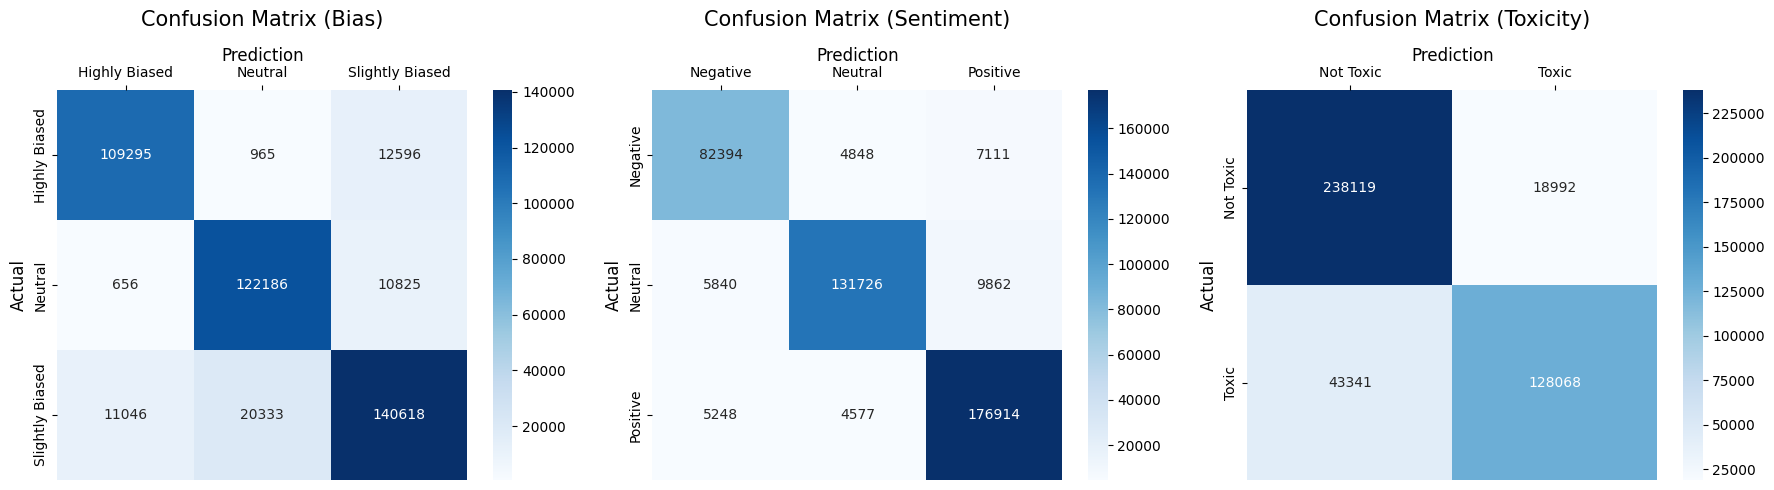

In [27]:
# confusion matrix.
def plot_cm(y_true, y_pred, labels, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax)
    ax.set_title(title, fontsize=15, pad=15)
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_cm(y_test_bias, y_pred_bias, ['Highly Biased', 'Neutral','Slightly Biased'], 'Confusion Matrix (Bias)', axes[0])
plot_cm(y_test_sentiment, y_pred_sentiment, ['Negative', 'Neutral', 'Positive'], 'Confusion Matrix (Sentiment)', axes[1])
plot_cm(y_test_toxic, y_pred_toxic, ['Not Toxic', 'Toxic'], 'Confusion Matrix (Toxicity)', axes[2])

plt.tight_layout()
plt.show()

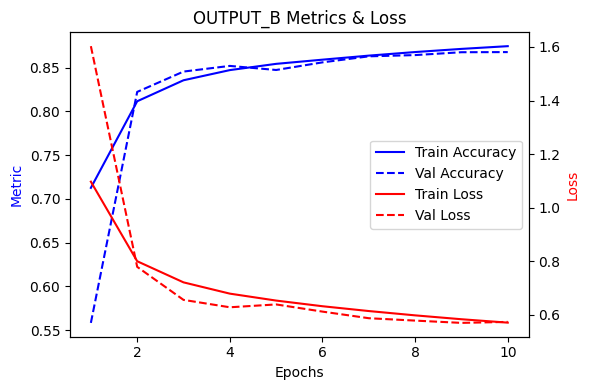

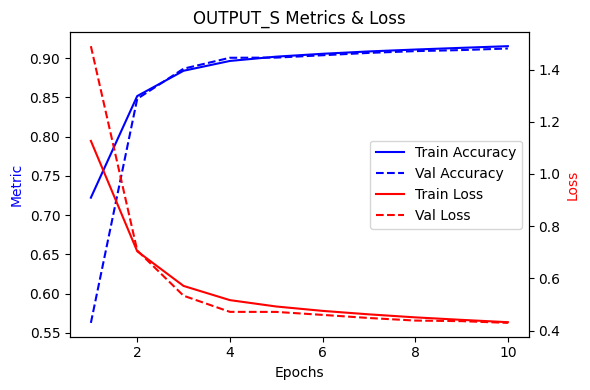

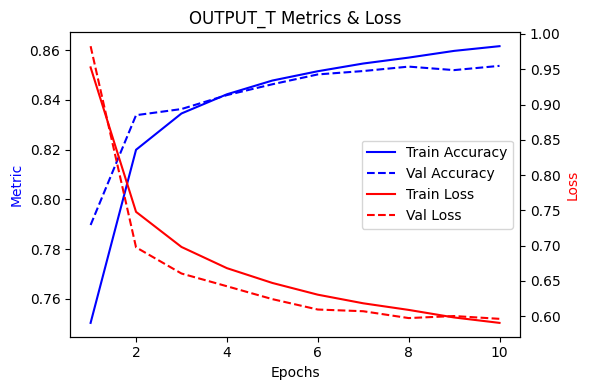

In [26]:
# loss and accuracy graphs.
def plot_history_combined(history, outputs, metrics=None):
    if metrics is None:
        metrics = []
        for key in history.history.keys():
            for output in outputs:
                if key.startswith(output) and not key.endswith("loss"):
                    metric_name = key[len(output)+1:]  # remove output_
                    if metric_name not in metrics:
                        metrics.append(metric_name)
    
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)
    for output in outputs:
        fig, ax1 = plt.subplots(figsize=(6, 4))

        # Plot accuracy on left y-axis
        ax2 = ax1.twinx()
        for metric in metrics:
            train_metric = history.history.get(f"{output}_{metric}")
            val_metric = history.history.get(f"val_{output}_{metric}")
            if train_metric and val_metric:
                ax1.plot(epochs, train_metric, "b-", label=f"Train {metric.title()}")
                ax1.plot(epochs, val_metric, "b--", label=f"Val {metric.title()}")

        # Plot loss on right y-axis
        train_loss = history.history.get(f"{output}_loss")
        val_loss = history.history.get(f"val_{output}_loss")
        if train_loss and val_loss:
            ax2.plot(epochs, train_loss, "r-", label="Train Loss")
            ax2.plot(epochs, val_loss, "r--", label="Val Loss")

        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Metric", color="b")
        ax2.set_ylabel("Loss", color="r")
        ax1.set_title(f"{output.upper()} Metrics & Loss")

        # Legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

        plt.tight_layout()
        plt.show()

outputs = ["output_b", "output_s", "output_t"]
plot_history_combined(history, outputs)